In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')
from pathlib import Path
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import random
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, balanced_accuracy_score, matthews_corrcoef
from scipy.stats import chi2_contingency
import math
import scipy.stats as stats

pip install fuzzywuzzy python-Levenshtein

# defining functions used

In [11]:
def barplot(df, group_cols):
    n_cols = len(group_cols)
    n_rows = math.ceil(n_cols / 5)
    fig_width = 15
    fig_height = 15
    fig, axs = plt.subplots(n_rows, 5, figsize=(fig_width, fig_height))
    axs = axs.flatten()

    for i, col in enumerate(group_cols):
        proportions_df = df.groupby([col, 'General Status']).size().unstack(fill_value=0)
        proportions_df = proportions_df.div(proportions_df.sum(axis=1), axis=0)

        ax = axs[i] 
        proportions_df.plot(kind='bar', stacked=True, color=['lightblue', 'orange'], ax=ax, use_index=False,sharex=True,sharey=True)
        ax.set_title(f'{col}', fontsize=10,wrap=True)
        ax.legend(title='Won Primary', loc='upper right', labels=['No', 'Yes'],fontsize=5)
    for j in range(i+1, len(axs)):
        fig.delaxes(axs[j])

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f"grid_race_win.png")
    plt.legend(title='Won Primary', loc='upper right', labels=['No', 'Yes'],fontsize=5)
    plt.show()
    
def binarize_cols(df, nan_threshold=20):
    few_NaNs_cols = []
    for col in df.columns:
        if (df[col].nunique(dropna=False) == 2) or (df[col].nunique(dropna=True) == 2):
            unique_vals = df[col].unique()
            if (unique_vals[0] !=0 and unique_vals[1] !=0):
                print(f"col:{col}\n0 means:{unique_vals[0]}\n1 means: {unique_vals[1]}\n")
                df[col] = df[col].replace({unique_vals[0]: int(0), unique_vals[1]: int(1)})
            df[col].fillna(0, inplace=True) #now this will only make sense tho if we OHE first.    
    return df

def drop_columns(df, col_lst):
    for i in col_lst:
        if i in df.columns:
            df = df.drop(i, axis=1)
    return df

def get_info(df):
    print(f"COL VALUE TYPES \n{df.dtypes} \n\ndf shape:{df.shape}\n\nall the columns:\n{df.columns}")

def get_ohe_cols(df, unique_limit=16, exclude = ['total_runners_house','total_runners']):
    #object_cols = df.select_dtypes(include=['object']).columns
    res = [col for col in df.columns if ((df[col].nunique(dropna=False) <= unique_limit) and (df[col].nunique(dropna=False)>=2) and (col != 'total_runners') and (col != 'General Status') and (col !='Total Endorsements'))]
    return res

def zero_dropper(df):
    for col in df.columns:
        if ((df[col].astype(int)==1).mean() >= 0.80):
            df = df.drop(col, axis=1)
    return df

def drop_VIF_col(X, threshold=2):
    while True:
        vif_info = pd.DataFrame()
        vif_info['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
        vif_info['Column'] = X.columns
        vif_info = vif_info.sort_values('VIF', ascending=False)
        max_VIF = vif_info['VIF'].iloc[0]

        if max_VIF > threshold:
            to_drop = vif_info['Column'].iloc[0]
            print(f"Dropped: {to_drop} with VIF of {max_VIF}")
            X = X.drop(to_drop, axis=1)
        else:
            break

    return X  # Returning the modified DataFrame

def convert_to_int_if_possible(df, col_lst):
    for column_name in col_lst:
        temp_col = pd.to_numeric(df[column_name], errors='coerce')
        if temp_col.isna().sum() == 0:
            if all(temp_col.dropna() == temp_col.dropna().astype(int)):
                df[column_name] = temp_col.astype(int)
    return df

def aic(X, y):
    best_features = []
    best_aic = float('inf')

    for feature in X.columns:
        # Create a temporary DataFrame with the current set of best features plus the new feature
        X_temp = sm.add_constant(X[best_features + [feature]])

       
        model = sm.Logit(y, X_temp)  # Fit the logistic regression model
        result = model.fit()  # disp=0 suppresses the fit output

        # Check AIC and update if it is lower
        if result.aic < best_aic:
            best_aic = result.aic
            best_features.append(feature)

    X_final = sm.add_constant(X[best_features])
    final_model = sm.GLM(y, X_final, family=sm.families.Binomial(), penalized=True)
    final_result = final_model.fit()

    print(f"{best_features}")
    return final_result.summary(), final_result.aic

def chi_square_test(df, columns_to_test, outcome_column, significance_level=0.05):
    significant_columns = {}
    just_cols = []

    for column in columns_to_test:
        contingency_table = pd.crosstab(df[column], df[outcome_column])
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        if p < significance_level:
            just_cols.append(column)
            significant_columns[column] = p
    return just_cols

# Loading dataset: 

In [12]:
house = pd.read_csv('dec10.csv')
house = convert_to_int_if_possible(house,list(house.columns))        

In [13]:
house.shape

(632, 49)

# Run a chi-square test on all the categorical columns to get significant predictors, and visualize these results
The chi-square test helps us answer the question, "Are any of the predictors in our dataset significantly associated with a candidate's election outcome?" The null hypothesis, that all regressors are not significantly associated with outcome, is rejected if the p-value for at least one predictor in our model is below 0.05. The predictors that are highly associated with cndidate outcome (column ```General Status```) are returned from our chi_square_test function. The barplots are the significant columns vs general status.
```categorical``` is any categorical column. 

```significant_cols``` are the significant ```categorical``` columns based on chi square analysis.


In [14]:
categorical = get_ohe_cols(house)
significant_categorical = chi_square_test(house, categorical, 'General Status')

the resulting significant categories plotted against general status 

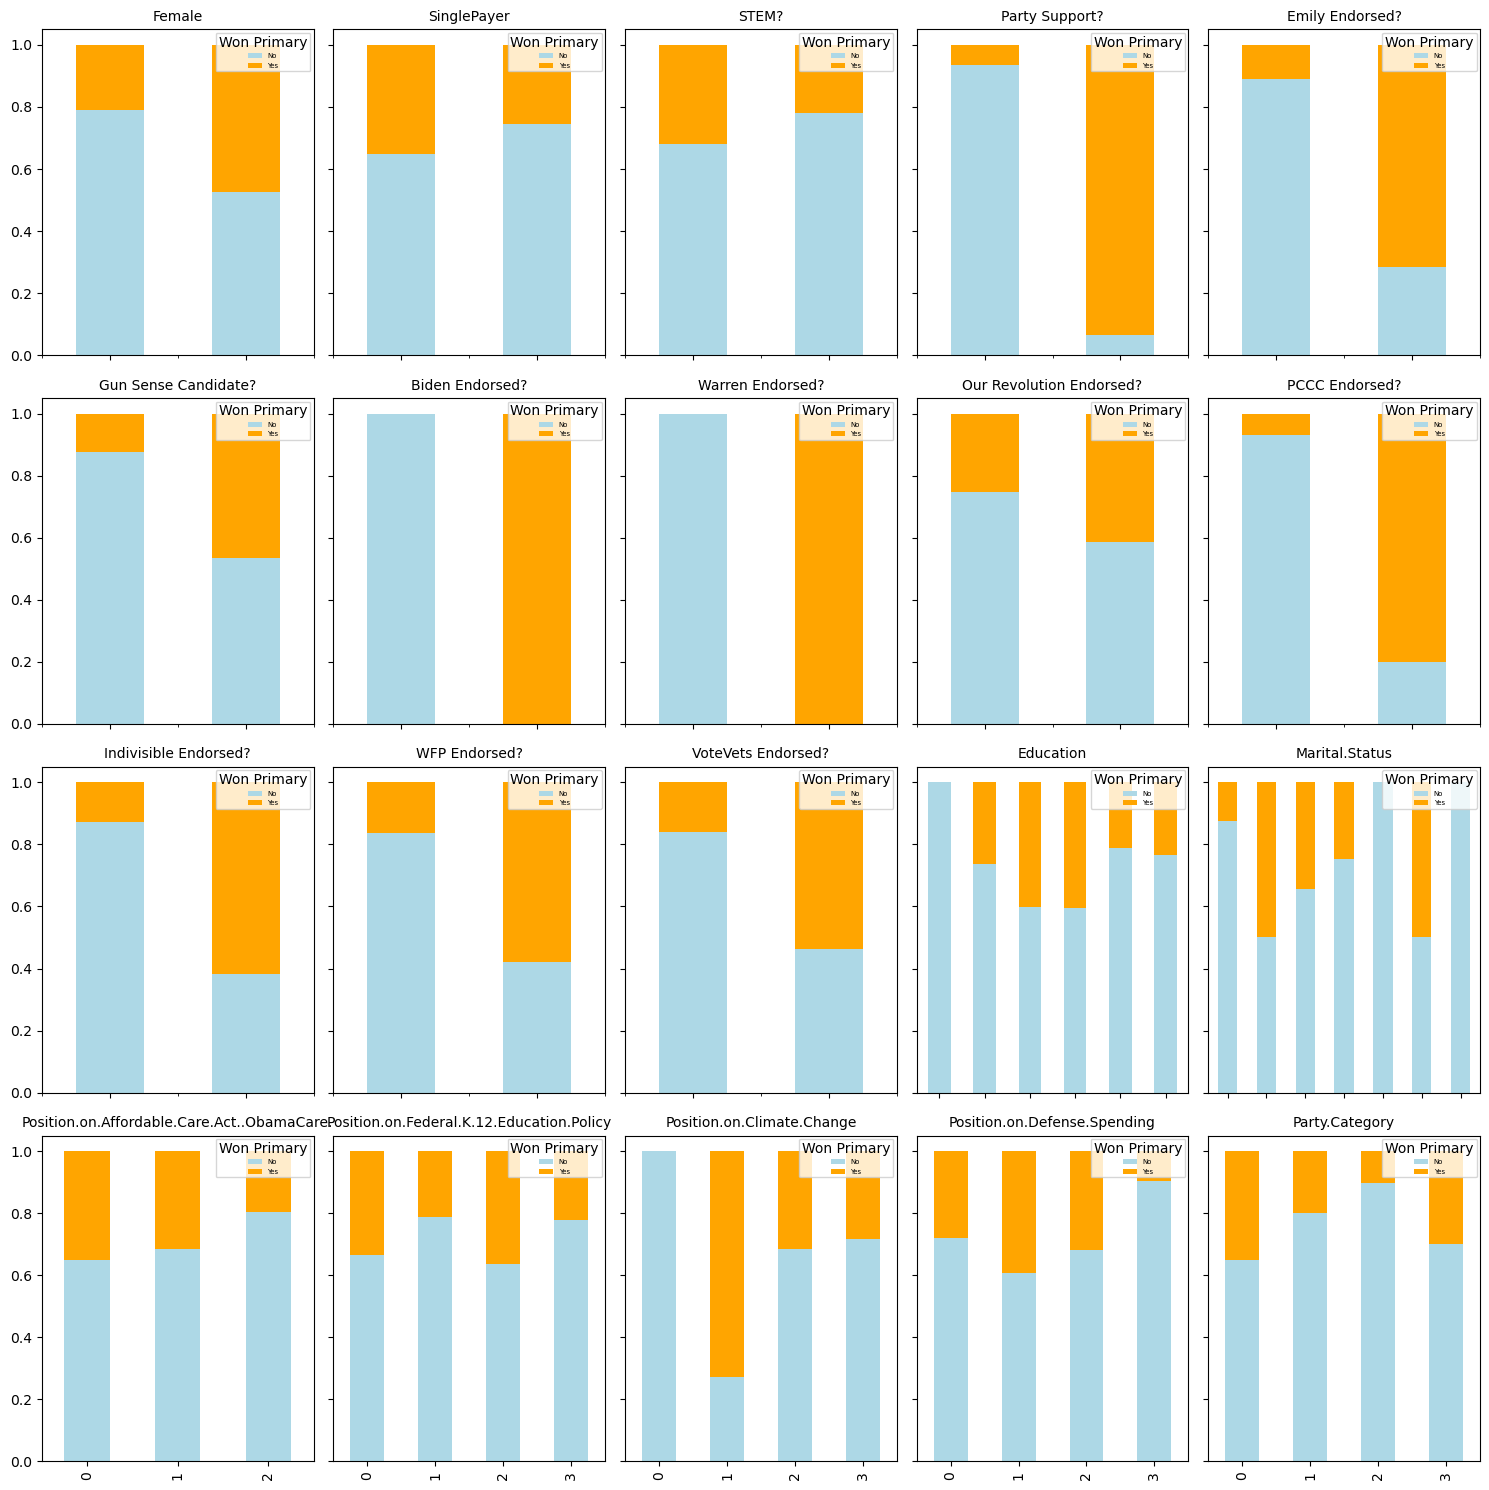

In [15]:
barplot(house, significant_categorical)

In [16]:
def pearson_correlations(df, numerical_columns, outcome_column, alpha=0.05):
    significant_cols = []
    for column in numerical_columns:
        correlation, p_value = stats.pearsonr(df[column], df[outcome_column])

        if p_value < alpha:
            significant_cols.append(column)
            print(f"{column}: Correlation = {correlation}, P-value = {p_value}")
    return significant_cols

In [17]:
numerical_only_df = house[['General Status','Partisan Lean','total_runners','Total Endorsements', 'receipts']]
significant_numerical = pearson_correlations(numerical_only_df, ['Partisan Lean'
                                                                   ,'total_runners'
                                                                   ,'Total Endorsements'
                                                                   , 'receipts'
                                                                  ]
                                               , 'General Status')


Partisan Lean: Correlation = -0.13122026778054272, P-value = 0.0009443435436934365
total_runners: Correlation = -0.22166983999234777, P-value = 1.7826270388831054e-08
Total Endorsements: Correlation = 0.3587730840040929, P-value = 1.2380213689295501e-20
receipts: Correlation = 0.464249505475202, P-value = 4.215457552940588e-35


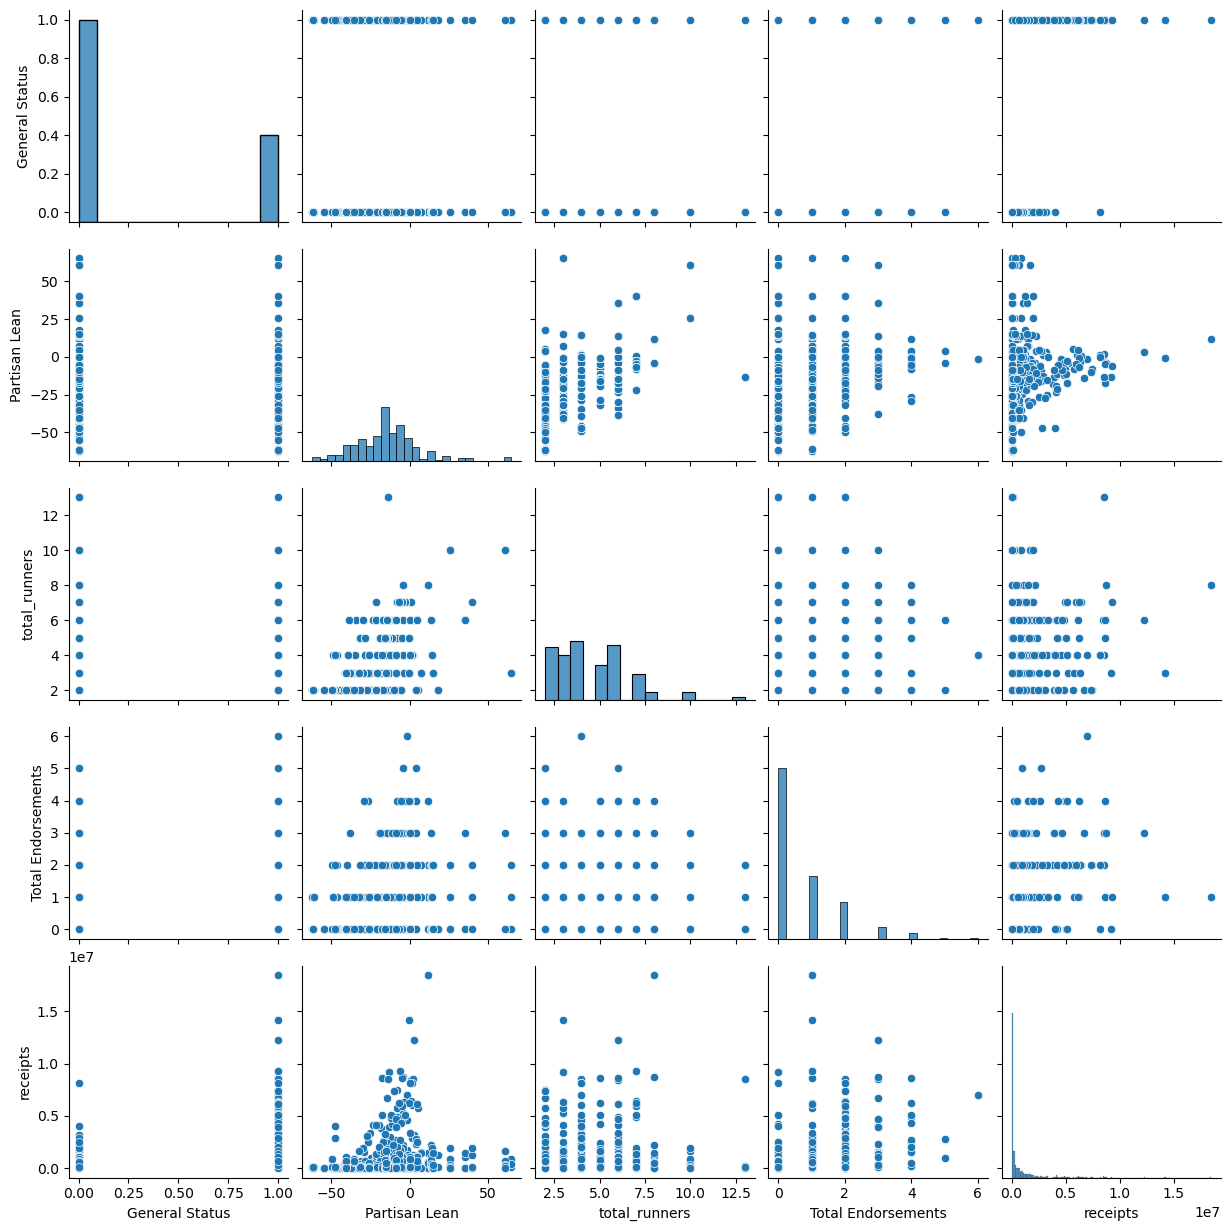

In [18]:
sns.pairplot(numerical_only_df)

# Now that we know which variables are significant, we will OHE just those, and drop all other categorical columns with no significance

```categorical``` is all categorical columns

```drop``` is the categories that are NOT significant

```house_to_encode``` is the house dataset with ```drop``` columns removed

In [23]:
drop = [x for x in categorical if x not in significant_categorical]
house_to_encode = drop_columns(house, drop)

Now we one hot encode all categorical columns in ```house_to_encode```

```significant_cols``` is the significant categorical cols based on chi sq test

```ohe_result``` is the result of this one-hot-encoded dataframe, with the original, unencoded ```significant_cols``` columns dropped

In [24]:
ohe_result = pd.get_dummies(house_to_encode, columns=significant_categorical)
ohe_result = drop_columns(ohe_result, significant_categorical)

to avoid multicollinearity must drop one column frmo each. to choose that column, we are selecting the least influential one for better interpretability.

```contains_no_info``` is all the columns that do 

```dependence_drop``` is the df with one OHE column dropped from each of the OHE features. 

In [25]:
contains_no_info =  [x for x in list(ohe_result.columns) if '_0' in x] + [x for x in list(ohe_result.columns) if '_No information' in x] + [x for x in list(ohe_result.columns) if '_Candidate provides complicated/complex/unclear position' in x] + [x for x in list(ohe_result.columns) if '_Candidate provides no information' in x] + [x for x in list(ohe_result.columns) if 'Other' in x]
dependence_drop = drop_columns(ohe_result, contains_no_info)

Now we want to do chi-square again as well as use domain knowledge to only use a subset of the columns.

```current columns``` is all the columns that we have right now.

```significant_cols_2``` is the result of doing chi-square on current dataframe (```dependence_drop```)

In [ ]:
current_columns = list(dependence_drop.columns)
significant_cols_2 = chi_square_test(dependence_drop, current_columns, 'General Status')

Now we should filter the dataframe to only contain the ```significant_cols_2```

In [ ]:
house_for_forward_sel = dependence_drop[significant_cols_2]

shuffle before doing the VIF. 

```re_shuffled``` is the df with columns reshuffled so when doing VIF it does it not in order

In [ ]:
re_shuffled = drop_low_variance.sample(frac=1, axis=1)

do VIF to drop highly correlated columns\

```X``` is all the X from ```re_shuffled```

```best_X``` is the result of dropping all highly multicollinear columns

```regression_ready``` is the dataframe with only the chosen ```best_X``` predicotrs

In [ ]:
X = drop_columns(re_shuffled, ['General Status'])
best_X = drop_VIF_col(X, 2)
#all_cols = ['General Status'] + list(best_X.columns)
regression_ready = re_shuffled[['General Status'] + list(best_X.columns)]

In [151]:
X = drop_columns(regression_ready, ['General Status'])

In [ ]:
def drop_highly_correlated_columns(df, threshold=0.5):
    # Compute the correlation matrix
    corr_matrix = df.corr().abs()

    # Identify pairs of highly correlated features
    to_drop = set()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] >= threshold:
                # Add one of the pair to the drop set
                to_drop.add(corr_matrix.columns[i])

    # Drop the selected columns
    df_reduced = df.drop(to_drop, axis=1)
    return df_reduced


In [ ]:
reduced_no_corr = drop_highly_correlated_columns(X)
regression_ready

In [ ]:
categorical = get_ohe_cols(reduced_no_corr)
significant_cols = chi_square_test(regression_ready, categorical, 'General Status')

In [ ]:
barplot(regression_ready, significant_cols)

In [156]:
drop = [x for x in categorical if x not in significant_cols]
house_for_aic = drop_columns(regression_ready, drop)

In [157]:
X_aic = house_for_aic.drop('General Status',axis=1)

In [158]:
aic(X_aic.astype(float),regression_ready['General Status'])

Optimization terminated successfully.
         Current function value: 0.600619
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.587919
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.561429
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.557118
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.550640
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.546662
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.530202
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.527916
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.523656
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.499598
  

(<class 'statsmodels.iolib.summary.Summary'>
 """
                  Generalized Linear Model Regression Results                  
 Dep. Variable:         General Status   No. Observations:                  632
 Model:                            GLM   Df Residuals:                      616
 Model Family:                Binomial   Df Model:                           15
 Link Function:                  Logit   Scale:                          1.0000
 Method:                          IRLS   Log-Likelihood:                -232.51
 Date:                Mon, 11 Dec 2023   Deviance:                       465.03
 Time:                        19:04:40   Pearson chi2:                 4.33e+03
 No. Iterations:                    21   Pseudo R-squ. (CS):             0.3855
 Covariance Type:            nonrobust                                         
                                                                                                                                         coef    std e

In [159]:
for_regression_cols = ['Gun Sense Candidate?_1.0', 'VoteVets Endorsed?_1.0', 'receipts', 'STEM?_1', 'Partisan Lean', 'Our Revolution Endorsed?_1.0', 'Party.Category_Establishment Democrat', 'Position.on.Defense.Spending_Candidate supports a reduction in military spending', 'Emily Endorsed?_1.0', 'Female_1']

In [160]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, balanced_accuracy_score, accuracy_score
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import seaborn as sns

Precision: 0.3630952380952381
Prevalence: 0.30063291139240506
Recall: 0.9839
Accuracy on test set: 0.43157894736842106


<Figure size 600x600 with 0 Axes>

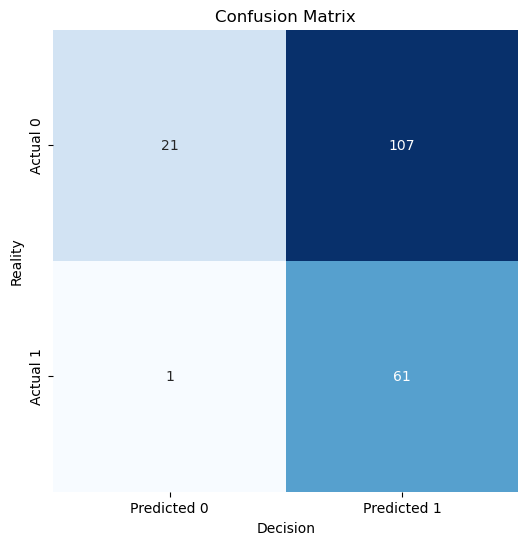

In [161]:
def do_regression(df, y_col, predictor_list): 
    
    train, test = train_test_split(df, test_size = .30, random_state = 101)
    X_train = train[predictor_list]
    y_train = train[y_col]
    X_test = test[predictor_list]
    y_test = test[y_col]
    logisticmodel = LogisticRegression(penalty='none', solver='lbfgs')
    logisticmodel.fit(X_test, y_test)
    probs = logisticmodel.predict_proba(X_test)[:, 1]
    y_hat = (probs > 0.5).astype(np.int64)
    accuracy = np.mean(y_test == y_hat)
    
    precision = precision_score(y_test, y_hat)
    recall = recall_score(y_test, y_hat)
    # Display the results
    print(f'Precision: {precision}')
    prevalence = np.mean(df[y_col] == 1)
    print(f"Prevalence: {prevalence}")
    print(f'Recall: {recall:.4f}')
    f1 = f1_score(y_test, y_hat)
    roc_auc = roc_auc_score(y_test, y_hat)
    average_precision = average_precision_score(y_test, y_hat)
    balanced_accuracy = balanced_accuracy_score(y_test, y_hat)
    print(f"Accuracy on test set: {accuracy}")
    confusionmatrix = confusion_matrix(y_test,y_hat)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(confusionmatrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted 0', 'Predicted 1'],
                yticklabels=['Actual 0', 'Actual 1']
               )
    plt.xlabel('Decision')
    plt.ylabel('Reality')
    plt.title('Confusion Matrix')
    plt.show()
    
    
# FP = output[( == 1) & (output.Reality == 0)].shape[0]
# FN = output[(output.Decisions == 0) & (output.Reality == 1)].shape[0]
# TP = output[(output.Decisions == 1) & (output.Reality == 1)].shape[0]
# TN = output[(output.Decisions == 0) & (output.Reality == 0)].shape[0]





# Plot the confusion matrix in a square format using seaborn
plt.figure(figsize=(6, 6))
# sns.heatmap(confusionmatrix, annot=True, fmt='d', cmap='Blues', cbar=False,
#             xticklabels=['Predicted 0', 'Predicted 1'],
#             yticklabels=['Actual 0', 'Actual 1']


do_regression(house_for_aic, 'General Status', for_regression_cols)

In [162]:
def do_regression_cv(df, y_col, predictor_list):
    X = df[predictor_list]
    y = df[y_col]

    logisticmodel = LogisticRegression(penalty='none', solver='lbfgs')

    # Using cross-validation
    scoring = ['precision', 'recall', 'f1', 'roc_auc', 'average_precision', 'accuracy']
    cv_results = cross_validate(logisticmodel, X, y, cv=10, scoring=scoring)

    # Display the results
    for score in scoring:
        print(f"{score.capitalize()}: {np.mean(cv_results['test_' + score]):.4f}")

    prevalence = np.mean(y == 1)
    print(f"Prevalence: {prevalence}")
    return logisticmodel


In [163]:
the_model = do_regression_cv(house_for_aic, 'General Status', for_regression_cols)

Precision: 0.3457
Recall: 0.9737
F1: 0.5086
Roc_auc: 0.8211
Average_precision: 0.7517
Accuracy: 0.4274
Prevalence: 0.30063291139240506
